<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/multi_class_Cyber_attack_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Load and Combine Training Data ---
print("Loading datasets...")
df1 = pd.read_csv('/content/Merged01.csv', low_memory=False)
df2 = pd.read_csv('/content/Merged02.csv', low_memory=False)
df = pd.concat([df1, df2], ignore_index=True)

# Clean column names for easier access
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
print(f"Loaded and combined data. Shape: {df.shape}")


# --- 2. Filter Out Any Remaining Benign Traffic ---
# Ensure we are only working with attack data as per the new goal
original_rows = len(df)
df = df[df['label'] != 'BENIGN'].copy()
print(f"Filtered out benign traffic. Kept {len(df)} attack rows.")


# --- 3. Define and Apply Attack Family Mapping ---
# This function maps the granular labels to broader families.
def map_label_to_family(label):
    if 'DDOS' in label.upper():
        return 'DDoS'
    if 'DOS' in label.upper():
        return 'DoS'
    if 'RECON' in label.upper():
        return 'Recon'
    if 'SPOOFING' in label.upper():
        return 'Spoofing'
    if 'MIRAI' in label.upper():
        return 'Mirai'
    if 'TCP_FLOOD' in label.upper() or 'UDP_FLOOD' in label.upper() or 'ICMP_FLOOD' in label.upper():
        return 'DDoS' # Catch common flood types not explicitly named DDoS
    return 'Other' # A catch-all for less common attacks

print("\nMapping detailed labels to attack families...")
df['attack_family'] = df['label'].apply(map_label_to_family)


# --- 4. Final Summary ---
# We will use 'attack_family' as our new target `y`
# The original 'label' column is no longer needed for modeling
X = df.drop(columns=['label', 'attack_family'])
y = df['attack_family']

print("\n--- New Multi-Class Label Summary ---")
print("Distribution of attack families:")
print(y.value_counts())

print("\nSample of the data with the new 'attack_family' column:")
# Display original label and new family side-by-side
print(df[['protocol_type', 'rate', 'label', 'attack_family']].head())

Loading datasets...
Loaded and combined data. Shape: (1460896, 40)
Filtered out benign traffic. Kept 1426676 attack rows.

Mapping detailed labels to attack families...

--- New Multi-Class Label Summary ---
Distribution of attack families:
attack_family
DDoS        1055752
DoS          251251
Mirai         81648
Spoofing      15240
Other         12980
Recon          9805
Name: count, dtype: int64

Sample of the data with the new 'attack_family' column:
   protocol_type          rate              label attack_family
0              6  25893.962218  DDOS-PSHACK_FLOOD          DDoS
1             47   3703.841331  MIRAI-GREIP_FLOOD         Mirai
2             17  19673.095685      DOS-UDP_FLOOD           DoS
3              6    261.664826       DNS_SPOOFING      Spoofing
4              1  28944.199848    DDOS-ICMP_FLOOD          DDoS


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
import joblib

print("Starting feature and label preprocessing...")

# --- 1. Encode the String Labels into Integers ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the fitted encoder for decoding predictions later
encoder_filename = 'label_encoder.joblib'
joblib.dump(label_encoder, encoder_filename)

print(f"Labels encoded and saved to '{encoder_filename}'.")
print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} -> {i}")


# --- 2. Define Feature Sets ---
# We use the feature DataFrame 'X' from the previous snippet
categorical_features = ['protocol_type']
numeric_features = [col for col in X.columns if col not in categorical_features]


# --- 3. Handle Outliers by Clipping ---
print("\nClipping numeric features to handle outliers...")
clipping_quantiles = X[numeric_features].quantile([0.005, 0.995])

X_clipped = X.copy()
for col in numeric_features:
    lower_bound = clipping_quantiles.loc[0.005, col]
    upper_bound = clipping_quantiles.loc[0.995, col]
    X_clipped[col] = X_clipped[col].clip(lower_bound, upper_bound)


# --- 4. Create and Fit the Feature Preprocessing Pipeline ---
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Fitting the feature preprocessing pipeline...")
preprocessor.fit(X_clipped)

# Save the fitted preprocessor
preprocessor_filename = 'preprocessor_multiclass.joblib'
joblib.dump(preprocessor, preprocessor_filename)
print(f"Feature preprocessor fitted and saved to '{preprocessor_filename}'.")


# --- 5. Demonstrate the Transformation ---
X_processed = preprocessor.transform(X_clipped)
print(f"\nData transformation complete. Shape of processed features: {X_processed.shape}")

Starting feature and label preprocessing...
Labels encoded and saved to 'label_encoder.joblib'.
Class mapping:
  DDoS -> 0
  DoS -> 1
  Mirai -> 2
  Other -> 3
  Recon -> 4
  Spoofing -> 5

Clipping numeric features to handle outliers...
Fitting the feature preprocessing pipeline...
Feature preprocessor fitted and saved to 'preprocessor_multiclass.joblib'.

Data transformation complete. Shape of processed features: (1426676, 43)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mode

# --- 1. Prepare Data ---
# We use the same pre-processed data and encoded labels as before.
df_base = pd.DataFrame(X_processed)
df_base['label'] = y_encoded

# Windowing parameters
WINDOW_LENGTH = 64
STRIDE = 32

all_windows_by_class = {}
class_names = label_encoder.classes_

print("Generating 'pure' windows for each attack family separately...")

# --- 2. Create Pure Windows for Each Class ---
for class_index, class_name in enumerate(class_names):
    # Isolate all data for the current class
    df_class = df_base[df_base['label'] == class_index].copy()

    # Skip if a class has too few samples to form a window
    if len(df_class) < WINDOW_LENGTH:
        print(f"  Skipping '{class_name}': Not enough data to form a window.")
        continue

    # Convert to numpy for fast windowing
    feature_data = df_class.drop(columns=['label']).values

    class_windows = []
    # This is a fast, vectorized way to create overlapping windows
    shape = (feature_data.shape[0] - WINDOW_LENGTH + 1, WINDOW_LENGTH, feature_data.shape[1])
    strides = (feature_data.strides[0], feature_data.strides[0], feature_data.strides[1])
    windows_for_class = np.lib.stride_tricks.as_strided(feature_data, shape=shape, strides=strides)[::STRIDE]

    all_windows_by_class[class_index] = windows_for_class
    print(f"  Generated {len(windows_for_class)} windows for '{class_name}'.")


# --- 3. Balance the Dataset by Downsampling ---
print("\nBalancing dataset by downsampling...")

# Find the class with the minimum number of windows
min_windows = min(len(v) for v in all_windows_by_class.values())
print(f"Smallest class has {min_windows} windows. Balancing all classes to this size.")

X_final_list, y_final_list = [], []

for class_index, windows in all_windows_by_class.items():
    # Randomly sample 'min_windows' from each class
    indices = np.random.choice(len(windows), min_windows, replace=False)

    X_final_list.append(windows[indices])
    # Create corresponding labels
    y_final_list.append(np.full(min_windows, class_index))

# Concatenate all balanced lists into final numpy arrays
X_windowed = np.concatenate(X_final_list, axis=0)
y_windowed = np.concatenate(y_final_list, axis=0)


# --- 4. Final Summary ---
print("\n--- Final Balanced Windowing Summary ---")
print(f"Shape of final windowed features (X_windowed): {X_windowed.shape}")
print(f"Shape of final windowed labels (y_windowed): {y_windowed.shape}")

print("\nLabel distribution in the final balanced set:")
window_label_counts = pd.Series(y_windowed).value_counts().sort_index()
window_label_counts.index = class_names[window_label_counts.index]
print(window_label_counts)

# Shuffle the final dataset to mix the classes
shuffled_indices = np.random.permutation(len(X_windowed))
X_windowed = X_windowed[shuffled_indices]
y_windowed = y_windowed[shuffled_indices]
print("\nFinal dataset has been shuffled.")

Generating 'pure' windows for each attack family separately...
  Generated 32991 windows for 'DDoS'.
  Generated 7850 windows for 'DoS'.
  Generated 2550 windows for 'Mirai'.
  Generated 404 windows for 'Other'.
  Generated 305 windows for 'Recon'.
  Generated 475 windows for 'Spoofing'.

Balancing dataset by downsampling...
Smallest class has 305 windows. Balancing all classes to this size.

--- Final Balanced Windowing Summary ---
Shape of final windowed features (X_windowed): (1830, 64, 43)
Shape of final windowed labels (y_windowed): (1830,)

Label distribution in the final balanced set:
DDoS        305
DoS         305
Mirai       305
Other       305
Recon       305
Spoofing    305
Name: count, dtype: int64

Final dataset has been shuffled.


In [ ]:
import numpy as np

# This command replaces any NaN values with 0.0 and any infinity values
# with very large finite numbers. It's a crucial step for stability.
print(f"Checking for invalid values. Before cleaning: {np.isnan(X_windowed).sum()} NaNs, {np.isinf(X_windowed).sum()} Infs")
X_windowed = np.nan_to_num(X_windowed)
print(f"After cleaning: {np.isnan(X_windowed).sum()} NaNs, {np.isinf(X_windowed).sum()} Infs")

Checking for invalid values. Before cleaning: 4 NaNs, 0 Infs
After cleaning: 0 NaNs, 0 Infs


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        41,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,270 (200.27 KB)

 Trainable params: 50,886 (198.77 KB)

 Non-trainable params: 384 (1.50 KB)


Starting robust model training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.7859 - sparse_categorical_accuracy: 0.3848 - val_loss: 0.6681 - val_sparse_categorical_accuracy: 0.7678
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5630 - sparse_categorical_accuracy: 0.7774 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8607
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4321 - sparse_categorical_accuracy: 0.8239 - val_loss: 0.2195 - val_sparse_categorical_accuracy: 0.9044
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3141 - sparse_categorical_accuracy: 0.8880 - val_loss: 0.1687 - val_sparse_categorical_accuracy: 0.9262
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.1380 - val_sparse_categorical_accuracy: 0.9454
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1955 - sparse_categorical_accuracy: 0.9298 - val_loss: 0.0873 - val_sparse_cate

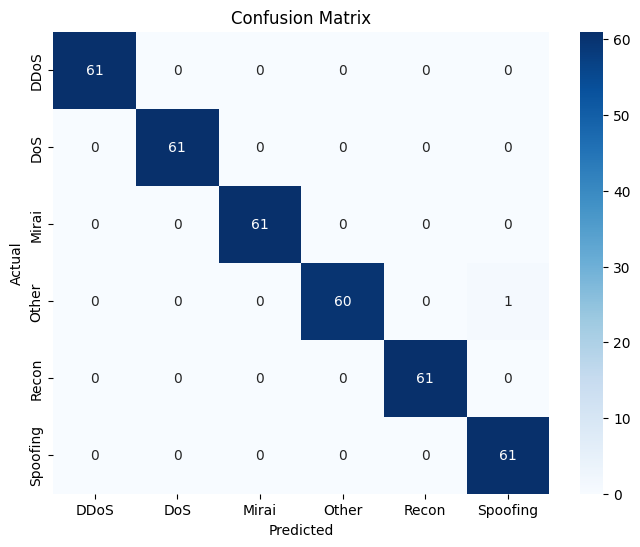

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Final Data Split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)

# --- 2. Define a More Robust Model Architecture ---
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=input_shape),
    Bidirectional(GRU(64, return_sequences=False)),
    # Batch Normalization stabilizes the network and helps prevent NaN loss
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Use an optimizer with gradient clipping to prevent exploding gradients
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.summary()

# --- 3. Train the Model ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nStarting robust model training...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# --- 4. Evaluate the Model ---
print("\nEvaluating model performance on the validation set...")
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = label_encoder.classes_

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout, Input, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Split Data ---
# Use the same cleaned and balanced X_windowed, y_windowed data
X_train, X_val, y_train, y_val = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)

# --- 2. Define the Hybrid Encoder Architecture ---
input_shape = (X_train.shape[1], X_train.shape[2]) # (64, 43)
num_classes = len(np.unique(y_train)) # 6

# Define the input layer
inputs = Input(shape=input_shape)

# CNN layers to capture local patterns (e.g., bursts)
x = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x) # Downsample

# BiGRU layer to capture long-range dependencies
# We name this layer to easily extract its output later
encoder_output = Bidirectional(GRU(64, return_sequences=False), name='encoder_output')(x)

# --- This part is the temporary head for training the encoder ---
head = BatchNormalization()(encoder_output)
head = Dropout(0.4)(head)
head = Dense(64, activation='relu')(head)
head = BatchNormalization()(head)
head = Dropout(0.4)(head)
outputs = Dense(num_classes, activation='softmax')(head)
# --- End of temporary head ---

# Create the model we will train
training_model = Model(inputs=inputs, outputs=outputs)

# Create the encoder model we will save and use later
encoder_model = Model(inputs=inputs, outputs=encoder_output)

# Compile the training model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
training_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

print("--- Full Model Architecture for Training ---")
training_model.summary()


# --- 3. Train the Encoder ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nStarting Encoder Training...")
history = training_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# --- 4. Save the Encoder ---
encoder_filename = 'cnn_gru_encoder.keras'
encoder_model.save(encoder_filename)
print(f"\nSuccessfully trained and saved the encoder to '{encoder_filename}'.")


# --- 5. Evaluate the Training Performance (Sanity Check) ---
print("\nEvaluating encoder's training performance on the validation set...")
y_pred_probs = training_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = label_encoder.classes_

print("\nClassification Report (during training):")
print(classification_report(y_val, y_pred, target_names=class_names))

--- Full Model Architecture for Training ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 43)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Bidirectional)  │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,022 (336.02 KB)

 Trainable params: 85,382 (333.52 KB)

 Non-trainable params: 640 (2.50 KB)


Starting Encoder Training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 1.8064 - sparse_categorical_accuracy: 0.3699 - val_loss: 0.9412 - val_sparse_categorical_accuracy: 0.6858
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8206 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.6027 - val_sparse_categorical_accuracy: 0.7623
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5130 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.3340 - val_sparse_categorical_accuracy: 0.8825
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.2562 - val_sparse_categorical_accuracy: 0.9235
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2431 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.1556 - val_sparse_categorical_accuracy: 0.9454
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.1281 - val_sparse_categoric

Successfully loaded the encoder from 'cnn_gru_encoder.keras'.

Generating embeddings for train and validation sets...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Shape of training embeddings: (1464, 128)
Shape of validation embeddings: (366, 128)

Training the XGBoost head...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:04:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Evaluating the final Hybrid Model (Encoder + XGBoost)...

Classification Report:
              precision    recall  f1-score   support

        DDoS       1.00      1.00      1.00        61
         DoS       1.00      0.98      0.99        61
       Mirai       1.00      0.98      0.99        61
       Other       0.97      1.00      0.98        61
       Recon       0.97      0.97      0.97        61
    Spoofing       1.00      1.00      1.00        61

    accuracy                           0.99       366
   macro avg       0.99      0.99      0.99       366
weighted avg       0.99      0.99      0.99       366


Confusion Matrix:


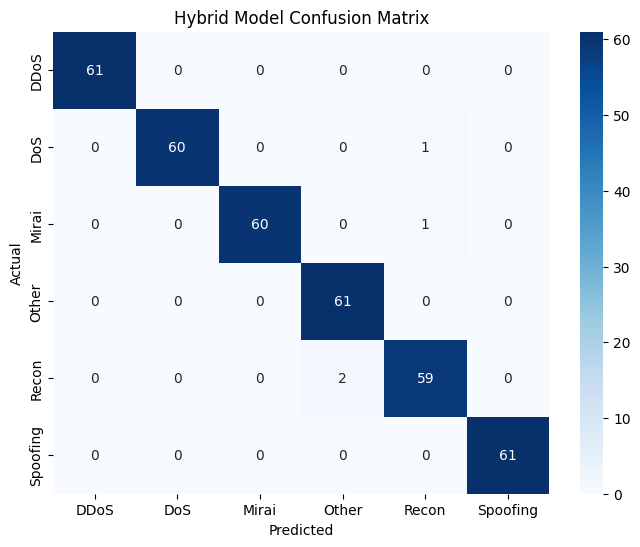


Generating SHAP explanations for the XGBoost head...

SHAP Global Feature Importance:


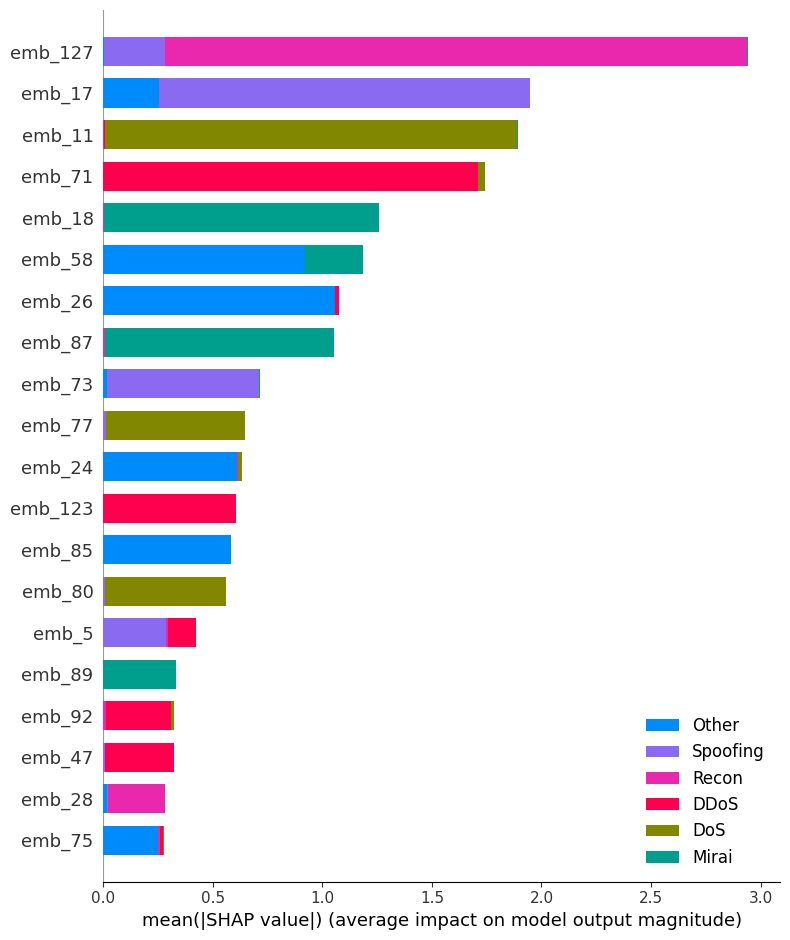


SHAP Detailed Summary Plot:


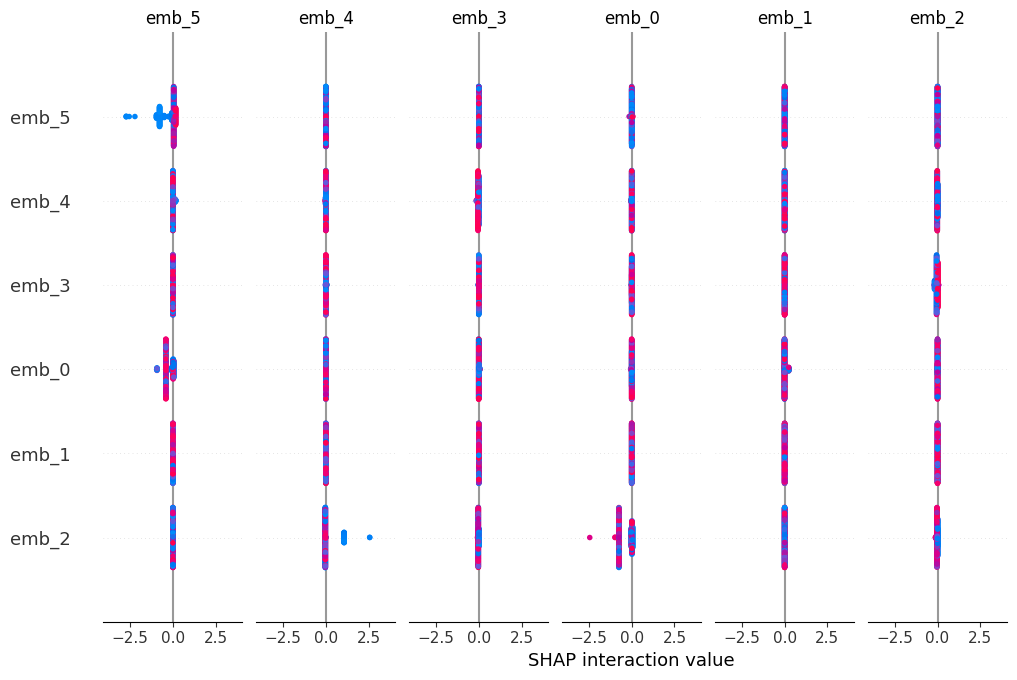

In [ ]:
import tensorflow as tf
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import shap
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load the Trained Encoder ---
encoder_filename = 'cnn_gru_encoder.keras'
encoder_model = tf.keras.models.load_model(encoder_filename)
print(f"Successfully loaded the encoder from '{encoder_filename}'.")


# --- 2. Generate Embeddings ---
# Use the encoder to transform our windowed data into fixed-size vectors
print("\nGenerating embeddings for train and validation sets...")
X_train_embeddings = encoder_model.predict(X_train)
X_val_embeddings = encoder_model.predict(X_val)

print(f"Shape of training embeddings: {X_train_embeddings.shape}")
print(f"Shape of validation embeddings: {X_val_embeddings.shape}")


# --- 3. Train the XGBoost Head ---
print("\nTraining the XGBoost head...")

# We use the embeddings as features for our XGBoost classifier
xgb_head = xgb.XGBClassifier(
    objective='multi:softprob', # for multi-class classification
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,          # Number of trees
    max_depth=6,
    learning_rate=0.1
)

xgb_head.fit(X_train_embeddings, y_train)


# --- 4. Evaluate the Final Hybrid Model ---
print("\nEvaluating the final Hybrid Model (Encoder + XGBoost)...")

y_pred = xgb_head.predict(X_val_embeddings)
class_names = label_encoder.classes_

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Hybrid Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# --- 5. Explainability with SHAP ---
print("\nGenerating SHAP explanations for the XGBoost head...")

# Create a SHAP explainer for our tree-based model
explainer = shap.TreeExplainer(xgb_head)
shap_values = explainer.shap_values(X_val_embeddings)

# Create a pandas DataFrame for better feature names in the plot
embedding_df = pd.DataFrame(X_val_embeddings, columns=[f'emb_{i}' for i in range(X_val_embeddings.shape[1])])

# Plot global feature importance
# This shows which embedding dimensions were most important overall.
print("\nSHAP Global Feature Importance:")
shap.summary_plot(shap_values, embedding_df, plot_type='bar', class_names=class_names)

# Plot detailed summary plot
# This shows how each feature dimension's value impacts the prediction for each class.
print("\nSHAP Detailed Summary Plot:")
shap.summary_plot(shap_values, embedding_df, class_names=class_names)